<a href="https://colab.research.google.com/github/DinisMartinho/AI-Powered-Sattelite-Mapping-Tool/blob/main/Colab%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets shutup --upgrade --quiet shutup
import torch, torchvision, matplotlib.pyplot, opendatasets, numpy, os, random, PIL, tqdm, shutup
shutup.please()

In [2]:
# GPU is required to run the notebook.
use_collab_gpu = True #@param {type:"boolean"}

In [3]:
if use_collab_gpu == True:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")

#### **● Discriminator**

In [4]:
class CNNBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, stride=2):
    super(CNNBlock, self).__init__()

    self.conv = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, bias=False, padding_mode="reflect"),
        torch.nn.InstanceNorm2d(out_channels, affine=True),
        torch.nn.LeakyReLU(0.2),
    )
  
  def forward(self, x):
    return self.conv(x)

In [5]:
class Discriminator(torch.nn.Module):
  def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
    super(Discriminator, self).__init__()

    self.initial = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
        torch.nn.LeakyReLU(),
    )

    layers = []
    in_channels = features[0]
    for feature in features[1:]:
      layers.append(
          CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
      )
      in_channels = feature
    
    layers.append(
        torch.nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect")
    )

    self.model = torch.nn.Sequential(*layers)
  
  def forward(self, x, y):
    x = torch.cat([x, y], dim=1)
    x = self.initial(x)
    return self.model(x)

#### **● Generator**

In [6]:
class Block(torch.nn.Module):
  def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
    super(Block, self).__init__()

    self.conv = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
        if down
        else torch.nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
        torch.nn.InstanceNorm2d(out_channels, affine=True),
        torch.nn.ReLU() if act=="relu" else torch.nn.LeakyReLU(0.2), 
    )
    self.use_dropout = use_dropout
    self.dropout = torch.nn.Dropout(0.5)
  
  def forward(self, x):
    x = self.conv(x)
    return self.dropout(x) if self.use_dropout else x

In [7]:
class Generator(torch.nn.Module):
  def __init__(self, in_channels=3, features=64):
    super(Generator, self).__init__()

    self.initial_down = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
        torch.nn.LeakyReLU(0.2),
    )

    self.down1 = Block(features*1, features*2, down=True, act="leaky", use_dropout=False)
    self.down2 = Block(features*2, features*4, down=True, act="leaky", use_dropout=False)
    self.down3 = Block(features*4, features*8, down=True, act="leaky", use_dropout=False)
    self.down4 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False)
    self.down5 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False)
    self.down6 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False)

    self.bottleneck = torch.nn.Sequential(
        torch.nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode="reflect"), torch.nn.ReLU(),
    )

    self.up1 = Block(features*8, features*8, down=False,   act="relu", use_dropout=True)
    self.up2 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=True)
    self.up3 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=True)
    self.up4 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=False)
    self.up5 = Block(features*8*2, features*4, down=False, act="relu", use_dropout=False)
    self.up6 = Block(features*4*2, features*2, down=False, act="relu", use_dropout=False)
    self.up7 = Block(features*2*2, features*1, down=False, act="relu", use_dropout=False)

    self.final_up = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
        torch.nn.Tanh(),
    )
  
  def forward(self, x):
    d1 = self.initial_down(x)
    d2 = self.down1(d1)
    d3 = self.down2(d2)
    d4 = self.down3(d3)
    d5 = self.down4(d4)
    d6 = self.down5(d5)
    d7 = self.down6(d6)

    bottleneck = self.bottleneck(d7)

    up1 = self.up1(bottleneck)
    up2 = self.up2(torch.cat([up1, d7], 1))
    up3 = self.up3(torch.cat([up2, d6], 1))
    up4 = self.up4(torch.cat([up3, d5], 1))
    up5 = self.up5(torch.cat([up4, d4], 1))
    up6 = self.up6(torch.cat([up5, d3], 1))
    up7 = self.up7(torch.cat([up6, d2], 1))
    return self.final_up(torch.cat([up7, d1], 1))

#### **● Custom dataset**

In [8]:
# You will need a kaggle account to download the dataset. 
opendatasets.download("https://www.kaggle.com/datasets/alincijov/pix2pix-maps")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dinismartinho
Your Kaggle Key: ··········


100%|██████████| 239M/239M [00:13<00:00, 19.0MB/s]


In [9]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, root_dir):
    self.root_dir = root_dir
    self.list_files = os.listdir(self.root_dir)

  def __len__(self):
    return len(self.list_files)

  def __getitem__(self, idx):
    img_path = self.list_files[idx]
    img_path = os.path.join(self.root_dir, img_path)
    img = PIL.Image.open(img_path)
      
    input_img = img.crop((0, 0, 600, img.height))
    target_img = img.crop((600, 0, img.width, img.height))

    # Apply random horizontal flip with the same parameter to both input and target images
    if random.random() < 0.5:
        input_img = torchvision.transforms.functional.hflip(input_img)
        target_img = torchvision.transforms.functional.hflip(target_img)
      
    # Apply random vertical flip with the same parameter to both input and target images
    if random.random() < 0.5:
        input_img = torchvision.transforms.functional.vflip(input_img)
        target_img = torchvision.transforms.functional.vflip(target_img)

    # Convert images to tensors and normalize
    input_img = torchvision.transforms.ToTensor()(input_img)
    target_img = torchvision.transforms.ToTensor()(target_img)
    input_img = torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(input_img)
    target_img = torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(target_img)

    input_img = torchvision.transforms.Resize((512, 512))(input_img)
    target_img = torchvision.transforms.Resize((512, 512))(target_img)

    return input_img, target_img

In [10]:
train_dataset = CustomDataset("/content/pix2pix-maps/train")
val_dataset = CustomDataset("/content/pix2pix-maps/val")

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, pin_memory=True)

#### **● Training Loop**

In [12]:
disc = Discriminator(in_channels=3).to(device)
gen = Generator(in_channels=3).to(device)

In [13]:
opt_disc = torch.optim.Adam(disc.parameters(), lr=3e-4, betas=(0.5, 0.999))
opt_gen  = torch.optim.Adam(gen.parameters(), lr=3e-4, betas=(0.5, 0.999))

In [14]:
BCE = torch.nn.BCEWithLogitsLoss()
L1_loss = torch.nn.L1Loss()

In [15]:
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

In [16]:
L1_lambda = 100

In [19]:
num_epochs = 5

In [20]:
for epoch in range(num_epochs):
  loop = tqdm.tqdm(train_loader, leave=True)

  for idx, (x, y) in enumerate(loop):
    x, y = x.to(device), y.to(device)

    # Train the Discriminator
    with torch.cuda.amp.autocast():
      y_fake = gen(x)
      D_real = disc(x, y)
      D_fake = disc(x, y_fake.detach())
      D_real_loss = BCE(D_real, torch.ones_like(D_real))
      D_fake_loss = BCE(D_fake, torch.zeros_like(D_real))
      D_loss = (D_real_loss + D_fake_loss) / 2
    opt_disc.zero_grad()
    d_scaler.scale(D_loss).backward()
    d_scaler.step(opt_disc)
    d_scaler.update()

    # Train the Generator
    with torch.cuda.amp.autocast():
      D_fake = disc(x, y_fake)
      G_fake_loss = BCE(D_fake, torch.ones_like(D_fake))
      L1 = L1_loss(y_fake, y) * L1_lambda
      G_loss = G_fake_loss + L1
    opt_gen.zero_grad()
    g_scaler.scale(G_loss).backward()
    g_scaler.step(opt_gen)
    g_scaler.update()

100%|██████████| 35/35 [00:52<00:00,  1.49s/it]


#### **● Inference Step**

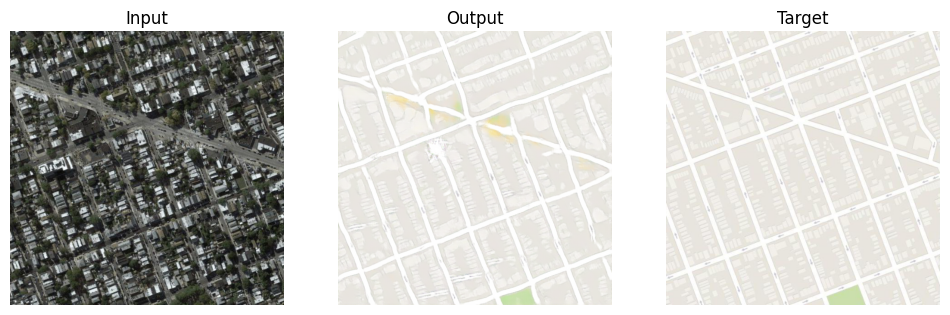

In [32]:
for input_image, target_image in val_loader:
  
    input_image = input_image.to(device)

    with torch.no_grad():
        output_image = gen(input_image)

    output_image = output_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
    target_image = target_image.squeeze(0).permute(1, 2, 0).numpy()

    input_image = numpy.squeeze(input_image.squeeze().cpu().permute(1, 2, 0).numpy()) * 0.5 + 0.5
    output_image = numpy.squeeze(output_image) * 0.5 + 0.5
    target_image = numpy.squeeze(target_image) * 0.5 + 0.5

    fig, axs = matplotlib.pyplot.subplots(1, 3, figsize=(12, 4))
    for ax, img, label in zip(axs, [input_image, output_image, target_image], ['Input', 'Output', 'Target']):
        ax.imshow(img)
        ax.set_title(label)
        ax.set_axis_off()
    matplotlib.pyplot.show()
    break

#### **● Load Pre-trained Weights**

In [ ]:
!pip install -U --no-cache-dir gdown --pre

In [ ]:
!gdown --no-cookies 1-4b6-15I8cOp4BFQ_7PMIx2tF9FULljX
!gdown --no-cookies 1-4XMLWM0JoBY_HRRrktDwSL1L_nr-14L

In [ ]:
gen.load_state_dict(torch.load("./generator.pth"))
disc.load_state_dict(torch.load("./discriminator.pth"))